In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from colorama import Fore
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA 
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("white")

## Load dataset

In [4]:
df = pd.read_csv("..\clean data\clean_data_train.csv")
data = df.drop(["Name", "Address"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                1011 non-null   int64  
 1   Size                 1011 non-null   int64  
 2   Distance to beach    1011 non-null   float64
 3   Distance to airport  1011 non-null   float64
 4   Pool                 1011 non-null   int64  
 5   Car                  1011 non-null   int64  
 6   Non-smoking room     1011 non-null   int64  
 7   Near beach           1011 non-null   int64  
 8   WiFi                 1011 non-null   int64  
 9   Family room          1011 non-null   int64  
 10  Bar                  1011 non-null   int64  
 11  Breakfast            1011 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 94.9 KB


- Chia khách sạn ra thành 4 phân khúc:
    - Standard: các khách sạn dưới 1 triệu đồng  (648 mẫu)
    - Premium: các khách sạn từ 1 đến 2 triệu đồng (195 mẫu)
    - Deluxe: các khách sạn từ 2 đến 4 triệu đồng (88 mẫu)
    - Luxury: các khách sạn từ 4 triệu trở lên (80 mẫu)
- Chia ra các mức như vậy để đảm bảo các mức giá càng cao sẽ có số lượng ít hơn so với các mức giá thấp cũng như số lượng mẫu ở các phân khúc không quá ít

In [5]:
data["Type"] = data["Price"].apply(lambda x: 0 if x<1500 else (1 if x < 5000 else 2))

## Phân chia train set và validation set

In [6]:
X = data.drop(["Type"] , axis=1)
y = data["Type"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
p_val = X_val["Price"]
X_train = X_train.drop(["Price"], axis = 1)
X_val = X_val.drop(["Price"], axis = 1)

## Hàm này dùng để đánh giá mô hình

Sử dụng 2 metrics: Accuracy và F1-score để đánh giá sơ bộ kết quả mô hình

In [7]:

#this function used to evaluate the models.
def models_score_cls(x_train, x_val, y_train, y_val):    
    models = {
        "Softmax": LogisticRegression(multi_class="multinomial"),
        "RandomForest":RandomForestClassifier()
         }
    evalutes = {}
    i = 0
    names = []
    accuracy = []
    f1_scores = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        accuracy.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    evalutes = {'Algorithms': names, 'Accuracy': accuracy, 'f1': f1_scores}
    model_scores = pd.DataFrame(evalutes)
    return model_scores

## Feature Extraction

### Khảo sát hiệu suất mô hình trước khi thực hiện trích xuất đặc trưng

In [8]:
score = models_score_cls(X_train, X_val, y_train, y_val)
score

,Algorithms,Accuracy,f1
0,Softmax,0.891626,0.767713
1,RandomForest,0.886700,0.806002


In [9]:
scores = []
for i in range(1, 12):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_val_pca = pca.transform(X_val)
  scores.append(models_score_cls(X_train_pca, X_val_pca, y_train, y_val))

best_score = scores[4] #kết quả tốt nhất khi n_components = 5
best_score

,Algorithms,Accuracy,f1
0,Softmax,0.896552,0.779299
1,RandomForest,0.901478,0.820251


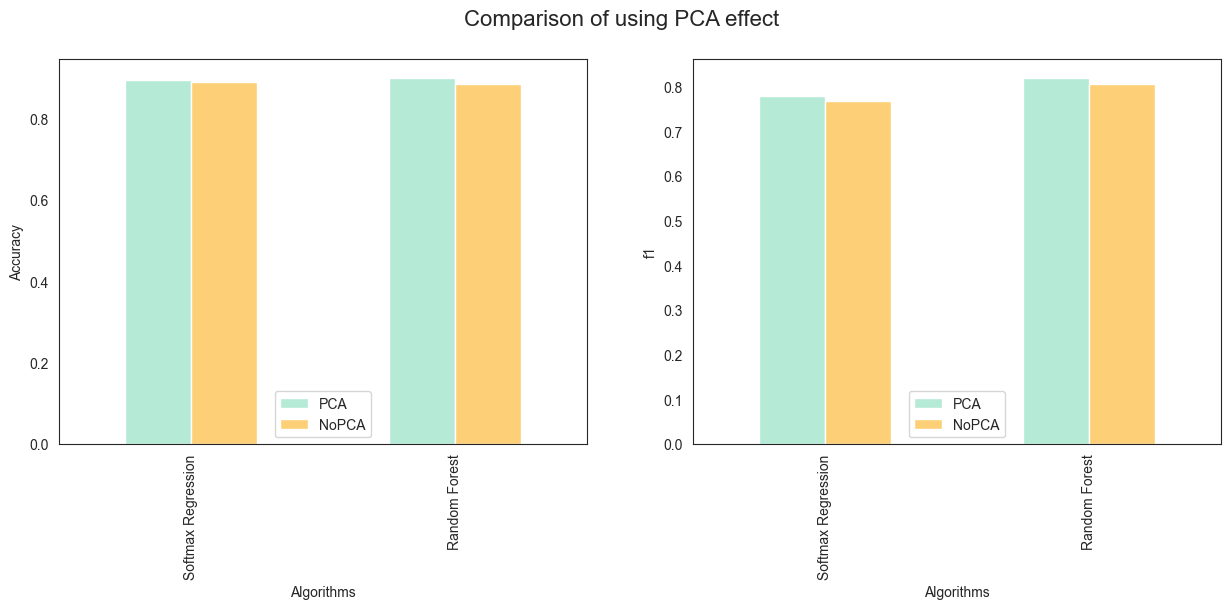

In [10]:

metrics = ["Accuracy", "f1"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison of using PCA effect', fontsize=16) 
for i in range(len(metrics)):
    df_comparea_pca = pd.DataFrame({
        'Algorithms': ["Softmax Regression", "Random Forest"],
        'PCA': [best_score[metrics[i]][0], best_score[metrics[i]][1]],
        'NoPCA': [score[metrics[i]][0], score[metrics[i]][1]],
    })
    df_comparea_pca.plot(x="Algorithms", y=["PCA", "NoPCA"], kind="bar", ax = axs[i], color=['#b5ead7', '#fdcf76']
)
    axs[i].set_ylabel(metrics[i])

=> PCA không cải thiện nhiều hiệu suất mô hình, vậy nên chúng ta không áp dụng PCA

### Tạo thêm các biến mới
- Ở đây, chúng ta sẽ tạo thêm 2 biến mới:
    - Ratio: tỉ lệ giữa khoảng cách từ khách sạn đến biển và khoảng cách từ khách sạn đến sân bay
    - Facilities: số lượng các dịch vụ được ưa chuộng nhất mà khách sạn cung cấp
- Dựa trên kết quả EDA, chúng ta sẽ muốn Ratio sẽ có mối quan hệ nghịch biến với Price
- Theo thường thức, Facilities nên có quan hệ đồng biến với Price

In [11]:
def create_new_feature(X):
    tmp = X.copy()
    facs = [ "Pool", "Bar",'Car','Non-smoking room','WiFi','Family room','Breakfast', "Near beach"]
    tmp["Facilities"] = X[facs].sum(axis =1)
    tmp["Ratio"] = X["Distance to beach"] / X["Distance to airport"]
    return tmp

In [12]:
X_train = create_new_feature(X_train)
X_val = create_new_feature(X_val)

## Feature Selection

### Đối với mô hình Softmax Regression

- Sử dụng Lasso Regression để loại bỏ đi những đặc trưng không quan trọng

In [24]:
from sklearn.linear_model import Lasso
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

selected_features = X_train.columns[lasso.coef_ != 0]
print(selected_features)


Index(['Size', 'Distance to airport', 'Ratio'], dtype='object')


### Đối với mô hình Random Forest

Feature: 0, Score: 0.40598
Feature: 1, Score: 0.09479
Feature: 2, Score: 0.15165
Feature: 3, Score: 0.03553
Feature: 4, Score: 0.02361
Feature: 5, Score: 0.01378
Feature: 6, Score: 0.01887
Feature: 7, Score: 0.01122
Feature: 8, Score: 0.01261
Feature: 9, Score: 0.02908
Feature: 10, Score: 0.00202
Feature: 11, Score: 0.06005
Feature: 12, Score: 0.14080


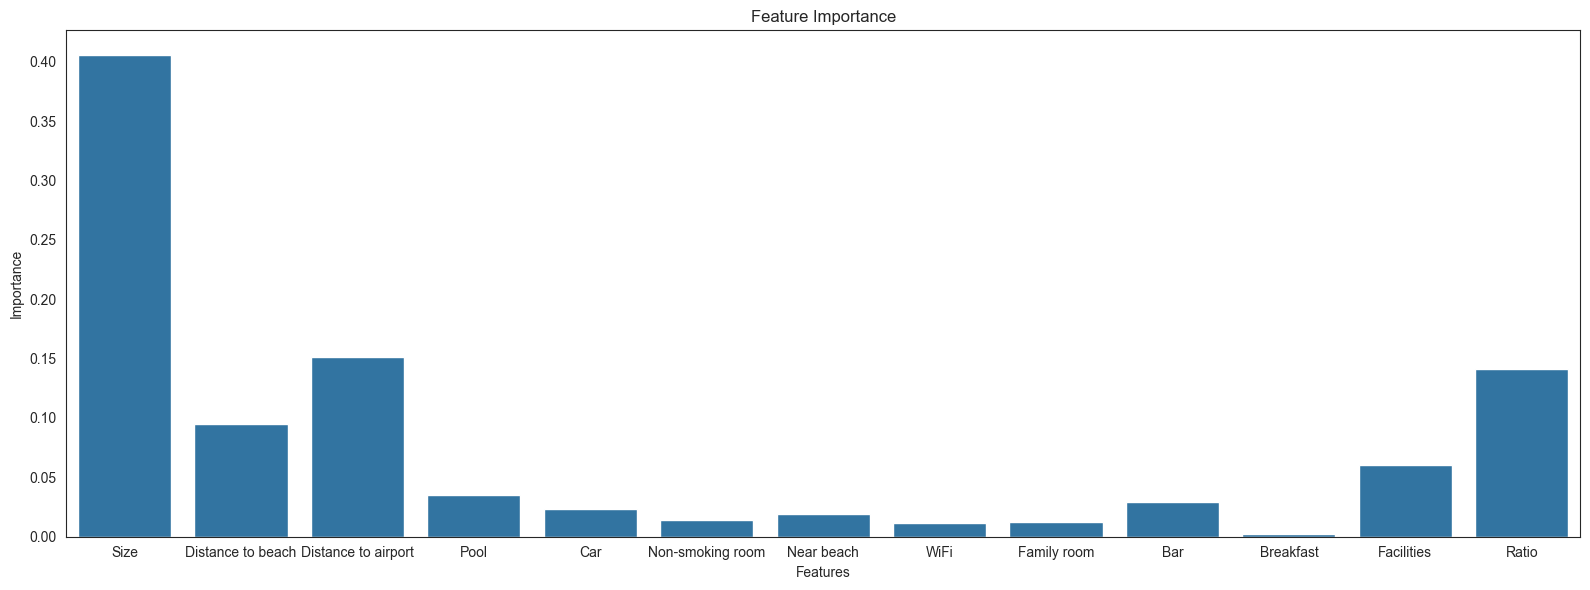

In [14]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(16, 6)) 
sns.barplot(x=list(X_train.columns), y=importance)


plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()

- Từ biểu đồ ta có thể lựa ra top 5 đặc trưng quan trọng nhất cho mô hình là:
    - Size
    - Distance to beach
    - Distance to airport
    - Ratio
    - Facilities

- Tương tự với bài toán Regression, ta sẽ chọn thêm 2 đặc trưng Pool và Bar cho mô hình

- Như vậy, 2 mô hình của chúng ta sẽ có 7 features:
    - Size
    - Distance to beach
    - Distance to airport
    - Pool
    - Bar
    - Ratio
    - Facilities

## Chọn ra những đặc trưng quan trọng

In [15]:
selected_features = ["Size", "Distance to beach", "Distance to airport", "Pool", "Bar", "Ratio", "Facilities"]

In [16]:
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_train

,Size,Distance to beach,Distance to airport,Pool,Bar,Ratio,Facilities
0,75,0.05,5.0,1,0,0.010000,2
1,23,3.50,0.6,0,0,5.833333,3
2,60,0.04,4.5,1,0,0.008889,4
3,28,0.20,4.3,1,0,0.046512,6
4,32,0.04,5.0,0,1,0.008000,6
...,...,...,...,...,...,...,...
803,25,5.00,8.0,0,0,0.625000,2
804,32,0.10,7.0,1,1,0.014286,6
805,25,0.15,4.4,1,1,0.034091,7
806,25,0.85,4.1,0,0,0.207317,5


## Feature Transformation

In [17]:
def scale_data(x):
    x = np.array(x)
    x = np.reshape(x, (len(x), 1))
    scaler = RobustScaler(quantile_range=(15,85))
    x = scaler.fit_transform(x)
    return x


def transform(x):
    x = np.array(x)
    x = np.log(x)
    return x

- Ở phần này, vì có những features trùng với bài toán Regression nên phương pháp và kết quả sẽ giống nhau, nhóm em sẽ chỉ vẽ lại kết quả

In [18]:
features = ["Size", "Distance to beach", "Distance to airport"]
for feature in features:
    X_train[feature] = scale_data(transform(X_train[feature]))
    X_val[feature] = scale_data(transform(X_val[feature]))

Text(0.5, 0, 'Distance to airport (km)')

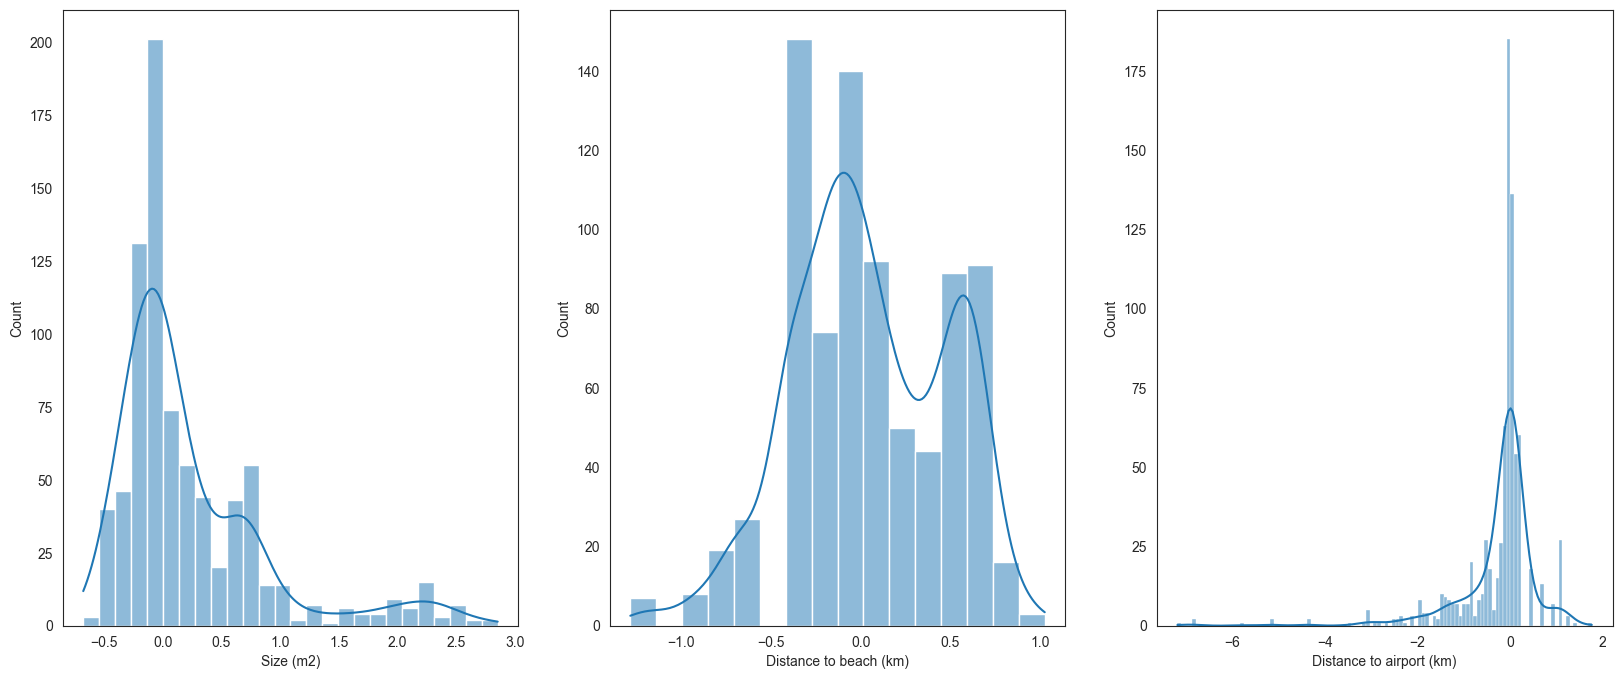

In [19]:

    
fig = plt.figure(figsize = (20, 8))
gs = gridspec.GridSpec(1, 3)

size = fig.add_subplot(gs[0, 0])
sns.histplot(data=X_train["Size"], ax = size, kde = True)
size.set_xlabel("Size (m2)")

beach = fig.add_subplot(gs[0, 1])
sns.histplot(data=X_train["Distance to beach"], ax = beach, kde = True)
beach.set_xlabel("Distance to beach (km)")

airport = fig.add_subplot(gs[0, 2])
sns.histplot(data=X_train["Distance to airport"], ax = airport, kde = True)
airport.set_xlabel("Distance to airport (km)")


## Xây dựng các model dùng cho việc dự đoán kết quả

In [20]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    # dùng để đánh giá mô hình trên metrics thông qua 4 metrics: MAE, RMSE, MAPE, R2 score
    def evaluate(self, y_true):
        self.accuracy = accuracy_score(y_true, self.y_pred)
        self.f1_score = f1_score(y_true, self.y_pred, average="macro")
        self.cm = confusion_matrix(y_true, self.y_pred, labels = self.model.classes_)
        
        print(Fore.GREEN + 'Accuracy: {}'.format(self.accuracy))
        print(Fore.GREEN + 'F1 score: {}'.format(self.f1_score))
        
        
        return self.accuracy, self.f1_score, self.cm      
        
class ModelSoftmaxRegression(Model):
    def __init__(self, regular = False):
        self.model = LogisticRegression(multi_class="multinomial")
    def train(self, X_train, y_train):
        
        self.model.fit(X_train, y_train)
        

class ModelRandomForestClassifier(Model):
    def __init__(self, model, search=False):
        self.model = model
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [1, 2, 4],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [None, 1, 2],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=5, n_jobs=-1, verbose=3, scoring = "accuracy")
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = self.model.set_params(**self.params)
            self.model.fit(X_train, y_train)
            print(grid_search.scorer_)

## Kết quả mô hình Softmax Regression

Accuracy: 0.896551724137931
F1 score: 0.7840033420097047


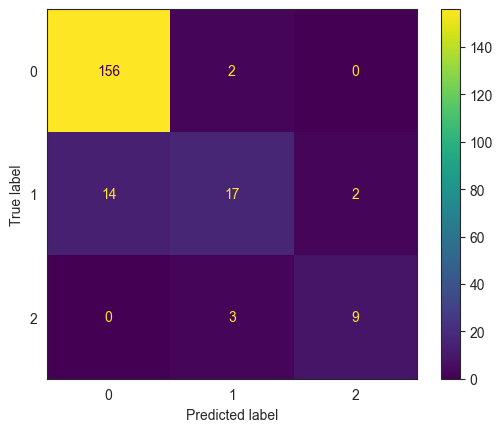

In [21]:
sfm = ModelSoftmaxRegression()
sfm.train(X_train, y_train)
y_pred = sfm.predict(X_val)
acc, f1, cm = sfm.evaluate(y_val)
disp = ConfusionMatrixDisplay(cm, display_labels=sfm.model.classes_)
disp.plot()

## Kết quả mô hình Random Forest

Accuracy: 0.8916256157635468
F1 score: 0.8060606060606061
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


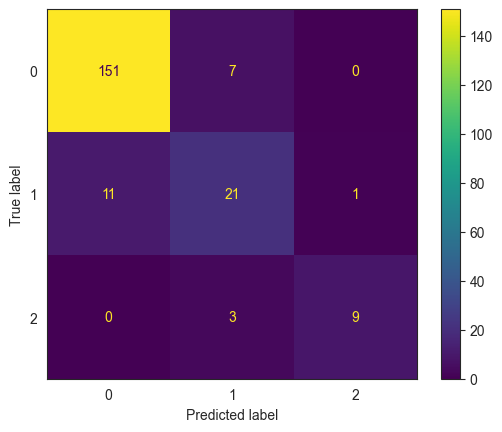

In [22]:
rdf = ModelRandomForestClassifier(RandomForestClassifier())
rdf.train(X_train, y_train)
y_pred = rdf.predict(X_val)
acc, f1, cm = rdf.evaluate(y_val)
disp = ConfusionMatrixDisplay(cm, display_labels=rdf.model.classes_)
disp.plot()
print(rdf.model.get_params())

### Thực hiện cross-validation

In [ ]:
rdf = ModelRandomForestClassifier(RandomForestClassifier(), search=True)
rdf.train(X_train, y_train)
y_pred = rdf.predict(X_val)
acc, f1, cm = rdf.evaluate(y_val)
disp = ConfusionMatrixDisplay(cm, display_labels=rdf.model.classes_)
disp.plot()
print(rdf.model.get_params())

## Triển khai mô hình trên Test data

### Xử lý biến Price: Xóa VND, chia 1000

In [ ]:
def convert(data):
    return int(data.split()[1].replace(".",""))

def scale(data):
    return round(data/1000)

### Load data test

In [ ]:
data_test = pd.read_csv("../raw data/raw_data_test.csv", index_col=0)
data_test["Price"] = data_test["Price"].apply(lambda x: scale(convert(x)))
data_test["Type"] = data_test["Price"].apply(lambda x: 0 if x<1500 else (1 if x < 5000 else 2))

### Thực hiện feature engineering trên data test

In [ ]:
X_test = data_test.drop(["Price", "Type"], axis = 1)
X_test = create_new_feature(X_test)                  #Tạo các biến mới
X_test = X_test[selected_features]                   #Lựa chọn đặc trưng
X_test = X_test.reset_index(drop=True)
y_test = data_test["Type"]
y_test_p = data_test["Price"]
y_test = y_test.reset_index(drop=True)
y_test_p = y_test_p.reset_index(drop=True)

### Chuẩn hóa các biến số thực

In [ ]:
features = ["Size", "Distance to beach", "Distance to airport"]
for fea in features:
    X_test[fea] = scale_data(transform(X_test[fea]))

In [ ]:
X_test.describe()

,Size,Distance to beach,Distance to airport,Pool,Bar,Ratio,Facilities
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.292643,0.044551,-0.273843,0.294118,0.245098,1.047287,3.558824
std,0.887377,0.494576,1.506988,0.457895,0.432270,5.457127,1.620253
min,-0.678291,-1.614168,-7.970122,0.000000,0.000000,0.002128,0.000000
25%,-0.206003,-0.267875,-0.261943,0.000000,0.000000,0.050000,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.109722,4.000000
75%,0.392610,0.474313,0.142911,1.000000,0.000000,0.385417,5.000000
max,3.903111,1.564906,4.531978,1.000000,1.000000,50.000000,7.000000


### Kết quả thực thi mô hình

### Softmax Regression

Accuracy: 0.8333333333333334
F1 score: 0.6913206135428358


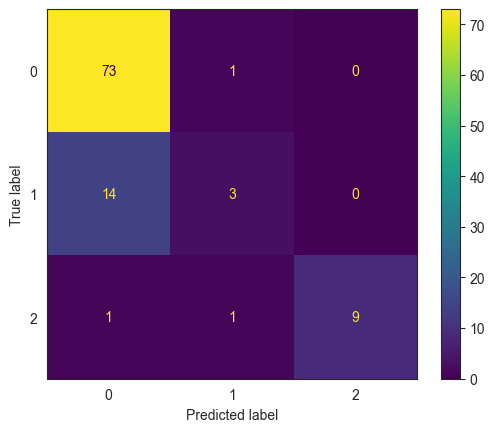

In [ ]:
pred = sfm.predict(X_test)
acc, f1, cm = sfm.evaluate(y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=sfm.model.classes_)
disp.plot()

### Random Forest

Accuracy: 0.8529411764705882
F1 score: 0.7284090909090909


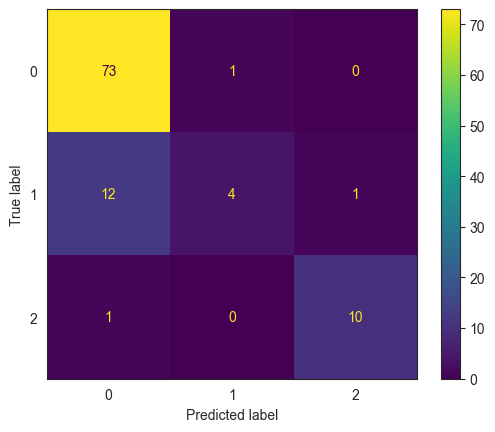

In [ ]:
pred = rdf.predict(X_test)
acc, f1, cm = rdf.evaluate(y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=rdf.model.classes_)
disp.plot()